## Импорт библиотек

In [1]:
import pandas as pd
import re

## Подкллючение датасета и установкка настроек для df

In [2]:
df =  pd.read_csv('/content/drive/MyDrive/BCC/channel_et_reason_dataset.csv')

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
df = df[['transcription', 'first_reason_channel', 'second_reason_channel', 'third_reason_channel']]

In [5]:
df['labels'] = df.apply(lambda row: list(filter(pd.notnull, [
    row['first_reason_channel'],
    row['second_reason_channel'],
    row['third_reason_channel']
])), axis=1)

In [6]:
df = df.drop_duplicates(subset='transcription')

## preprocess of text

In [7]:
def preprocess_text_trim_ends(text, start_chars=200, end_chars=100):
    text = str(text).strip()

    if len(text) > start_chars:
        text = text[start_chars:]
    else:
        return ''

    if len(text) > end_chars:
        text = text[:-end_chars]

    return text.lower().strip()
df['text_clean'] = df['transcription'].apply(preprocess_text_trim_ends)

In [8]:


def clean_interjections(text):
    text = str(text).lower()

    patterns = [
        r'\b(мхм+)\b',
        r'\b(ммм+)\b',
        r'\b(iii+)\b'
        r'\b(угу+)\b',
        r'\b(аа+)\b',
        r'\b(ыы+)\b',
        r'\b(ма+)\b',
        r'\b(а+)\b',
        r'\b(иә(\sиә)+)\b',
        r'\b(хорошо(\sхорошо)+)\b',
        r'\b(да(\sда)+)\b',
        r'\b(ха(\sха)+)\b',
        r'\b(нет(\sнет)+)\b',
    ]

    for pattern in patterns:
        text = re.sub(pattern, ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [9]:
df['text_clean'] = df['text_clean'].apply(clean_interjections)

In [10]:
def remove_single_char_words(text):
    words = text.split()
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)

In [11]:
df['text_clean'] = df['text_clean'].apply(remove_single_char_words)

In [12]:
def remove_ii_patterns(text):
    return re.sub(r'\b[иiі]{2,}\b', ' ', text)

In [13]:
df['text_clean'] = df['text_clean'].apply(remove_ii_patterns)

In [14]:
def clean_repetitive_noise(text: str) -> str:

    noise_patterns = [
        r'\b(мхм|угу|аа+|ыы+|иә(?:\sиә)+|да(?:\sда)+|жақсы(?:\sжақсы)+|хорошо(?:\sхорошо)+)\b',
        r'\b(вот так вот|сол сияқты|не знаю|ну вот|как бы|ну да)\b',
    ]

    for pattern in noise_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s{2,}', ' ', text)

    return text.strip()

In [15]:
df['text_clean'] = df['text_clean'].apply(clean_repetitive_noise)

## Подготовка датасета

In [16]:
df_melted = df.melt(
    id_vars=["text_clean"],
    value_vars=["first_reason_channel", "second_reason_channel", "third_reason_channel"],
    value_name="label"
).dropna(subset=["label"])


df_last = df_melted[["text_clean", "label"]].drop_duplicates().reset_index(drop=True)

In [17]:
label_counts = df_last['label'].value_counts()


valid_labels = label_counts[label_counts >= 100].index


df2 = df_last[df_last['label'].isin(valid_labels)].reset_index(drop=True)

In [18]:
df2['label'].value_counts()

,count
label,
АТМ,3974
Отделение,1091
Мобильное приложение BCC.KZ,295
ИПТ,103


## Настройки модели и импорты

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelBinarizer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "intfloat/multilingual-e5-small"
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
THRESHOLD = 0.5


## Сама модель ( обозначени x y  деление на train, test , val)

In [21]:
lb = LabelBinarizer()
lb.fit(df2["label"])
df2["label_bin"] = df2["label"].map(lambda x: lb.transform([x])[0])

# Обновим X и y
X = df2["text_clean"]
y = np.vstack(df2["label_bin"].values)

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=df2["label"])
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,
    random_state=42,
    stratify=y_train_val.argmax(axis=1)
)

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = MultiLabelDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = MultiLabelDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = MultiLabelDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

## Дообучение модели

In [24]:
class E5MultiLabelClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]
        return self.classifier(cls_token)

model = E5MultiLabelClassifier(MODEL_NAME, y.shape[1]).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()


config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

In [25]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f}")


[Epoch 1] Train Loss: 0.3494
[Epoch 2] Train Loss: 0.2579
[Epoch 3] Train Loss: 0.2235
[Epoch 4] Train Loss: 0.1977
[Epoch 5] Train Loss: 0.1749


## Check  точности модели и нахождение оптимального трешхолда

In [26]:
OPTIMAL_THRESHOLD = 0.2746
from sklearn.metrics import f1_score
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > OPTIMAL_THRESHOLD).int()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_labels), np.vstack(all_preds)

y_true, y_pred = evaluate(model, test_loader)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=lb.classes_))

print("\nConfusion Matrices:")
conf_mtx = multilabel_confusion_matrix(y_true, y_pred)
for i, label in enumerate(lb.classes_):
    print(f"\nLabel: {label}")
    print(conf_mtx[i])
f1_samples = f1_score(y_true, y_pred, average="samples")
print(f"\nF1 Score (samples): {f1_samples:.4f}")


Classification Report:
                             precision    recall  f1-score   support

                        АТМ       0.91      0.99      0.95       597
                        ИПТ       0.71      0.33      0.45        15
Мобильное приложение BCC.KZ       0.57      0.57      0.57        44
                  Отделение       0.85      0.87      0.86       164

                  micro avg       0.88      0.93      0.90       820
                  macro avg       0.76      0.69      0.71       820
               weighted avg       0.87      0.93      0.90       820
                samples avg       0.90      0.93      0.91       820


Confusion Matrices:

Label: АТМ
[[162  61]
 [  6 591]]

Label: ИПТ
[[803   2]
 [ 10   5]]

Label: Мобильное приложение BCC.KZ
[[757  19]
 [ 19  25]]

Label: Отделение
[[631  25]
 [ 21 143]]

F1 Score (samples): 0.9110


🚀 Запуск оптимизации threshold'ов...
🔍 Получение вероятностей на валидационной выборке...
🎯 Поиск оптимальных threshold'ов...

📊 Результаты на валидации:
Глобальный оптимальный threshold: 0.2414 (F1: 0.9028)
Индивидуальные threshold'ы:
  АТМ: 0.7616 (F1: 0.9457)
  ИПТ: 0.2356 (F1: 0.5000)
  Мобильное приложение BCC.KZ: 0.2291 (F1: 0.5618)
  Отделение: 0.6527 (F1: 0.8562)

🧪 Тестирование на test set...

📈 Сравнение результатов на test set:
Strategy             F1 Samples   F1 Macro     F1 Micro    
Fixed 0.5            0.8955       0.6300       0.9013      
Global Optimal       0.9091       0.7210       0.8988      
Individual Optimal   0.8911       0.7409       0.8990      


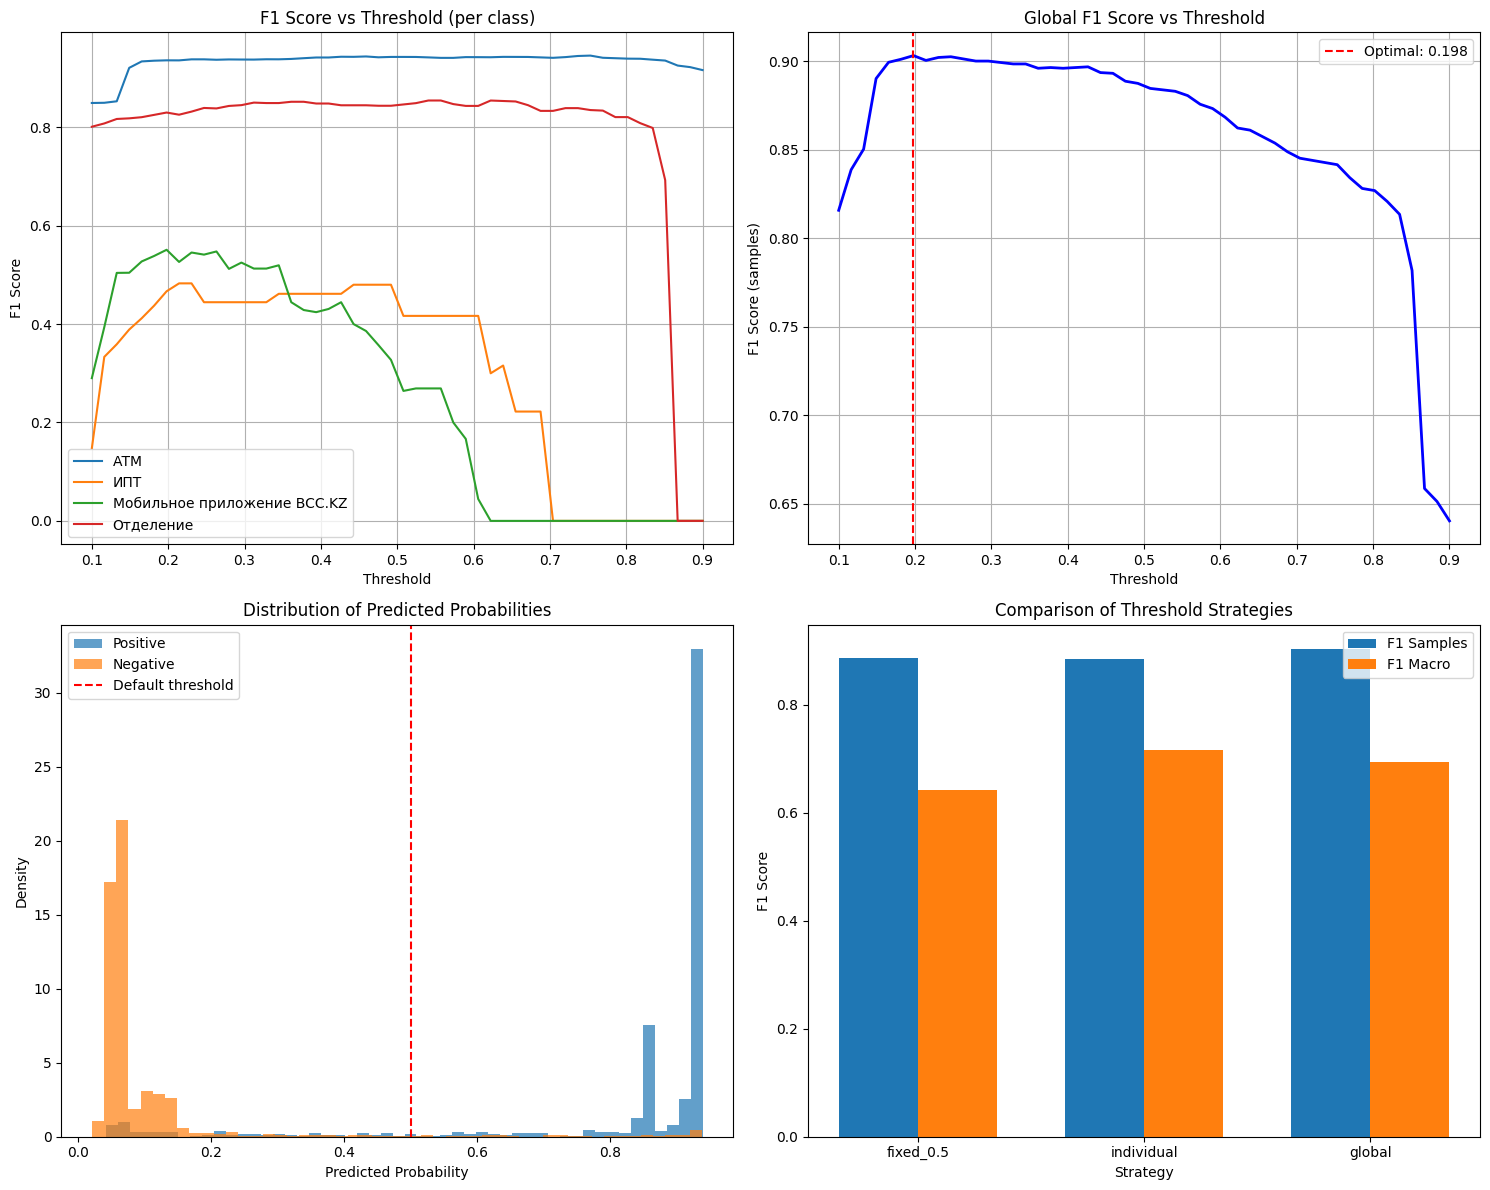

In [27]:

from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def get_probabilities(model, dataloader):
    """Получение вероятностей (без применения threshold)"""
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_labels), np.vstack(all_probs)

def find_optimal_threshold_per_class(y_true, y_probs, metric='f1'):
    """
    Находит оптимальный threshold для каждого класса

    Args:
        y_true: истинные метки (n_samples, n_classes)
        y_probs: предсказанные вероятности (n_samples, n_classes)
        metric: метрика для оптимизации ('f1', 'precision', 'recall', 'youden')

    Returns:
        optimal_thresholds: список оптимальных порогов для каждого класса
        metrics_per_class: метрики для каждого класса
    """
    n_classes = y_true.shape[1]
    optimal_thresholds = []
    metrics_per_class = []

    for i in range(n_classes):
        y_true_class = y_true[:, i]
        y_prob_class = y_probs[:, i]

        # Пропускаем классы, где все метки одинаковые
        if len(np.unique(y_true_class)) == 1:
            optimal_thresholds.append(0.5)
            metrics_per_class.append(0.0)
            continue

        if metric == 'f1':
            # Используем precision-recall кривую для F1
            precision, recall, thresholds = precision_recall_curve(y_true_class, y_prob_class)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
            best_metric = f1_scores[best_idx]

        elif metric == 'youden':
            # Индекс Youden (максимум TPR - FPR)
            fpr, tpr, thresholds = roc_curve(y_true_class, y_prob_class)
            youden_index = tpr - fpr
            best_idx = np.argmax(youden_index)
            best_threshold = thresholds[best_idx]
            best_metric = youden_index[best_idx]

        optimal_thresholds.append(best_threshold)
        metrics_per_class.append(best_metric)

    return optimal_thresholds, metrics_per_class

def find_global_threshold(y_true, y_probs, metric='f1_samples'):
    """
    Находит один глобальный threshold для всех классов
    """
    def objective(threshold):
        y_pred = (y_probs >= threshold).astype(int)

        if metric == 'f1_samples':
            return -f1_score(y_true, y_pred, average='samples', zero_division=0)
        elif metric == 'f1_macro':
            return -f1_score(y_true, y_pred, average='macro', zero_division=0)
        elif metric == 'f1_micro':
            return -f1_score(y_true, y_pred, average='micro', zero_division=0)

    result = minimize_scalar(objective, bounds=(0.01, 0.99), method='bounded')
    return result.x, -result.fun

def evaluate_thresholds(y_true, y_probs, thresholds, class_names=None):
    """
    Оценка качества с разными threshold стратегиями
    """
    results = {}

    # 1. Фиксированный 0.5
    y_pred_fixed = (y_probs >= 0.5).astype(int)
    results['fixed_0.5'] = {
        'f1_samples': f1_score(y_true, y_pred_fixed, average='samples', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred_fixed, average='macro', zero_division=0),
        'f1_micro': f1_score(y_true, y_pred_fixed, average='micro', zero_division=0)
    }

    # 2. Индивидуальные threshold для каждого класса
    if isinstance(thresholds, list):
        y_pred_individual = np.zeros_like(y_probs)
        for i, thresh in enumerate(thresholds):
            y_pred_individual[:, i] = (y_probs[:, i] >= thresh).astype(int)

        results['individual'] = {
            'f1_samples': f1_score(y_true, y_pred_individual, average='samples', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred_individual, average='macro', zero_division=0),
            'f1_micro': f1_score(y_true, y_pred_individual, average='micro', zero_division=0),
            'thresholds': thresholds
        }

    # 3. Глобальный оптимальный threshold
    else:
        y_pred_global = (y_probs >= thresholds).astype(int)
        results['global'] = {
            'f1_samples': f1_score(y_true, y_pred_global, average='samples', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred_global, average='macro', zero_division=0),
            'f1_micro': f1_score(y_true, y_pred_global, average='micro', zero_division=0),
            'threshold': thresholds
        }

    return results

def plot_threshold_analysis(y_true, y_probs, class_names=None):
    """
    Визуализация анализа threshold'ов
    """
    n_classes = y_true.shape[1]
    if class_names is None or len(class_names) == 0:
        class_names = [f'Class_{i}' for i in range(n_classes)]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. F1 score vs threshold для каждого класса
    ax1 = axes[0, 0]
    thresholds_range = np.linspace(0.1, 0.9, 50)

    for i in range(min(n_classes, 5)):  # показываем только первые 5 классов
        f1_scores = []
        for thresh in thresholds_range:
            y_pred = (y_probs[:, i] >= thresh).astype(int)
            f1 = f1_score(y_true[:, i], y_pred, zero_division=0)
            f1_scores.append(f1)
        ax1.plot(thresholds_range, f1_scores, label=class_names[i])

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 Score')
    ax1.set_title('F1 Score vs Threshold (per class)')
    ax1.legend()
    ax1.grid(True)

    # 2. Global F1 samples vs threshold
    ax2 = axes[0, 1]
    f1_samples_scores = []
    for thresh in thresholds_range:
        y_pred = (y_probs >= thresh).astype(int)
        f1_samples = f1_score(y_true, y_pred, average='samples', zero_division=0)
        f1_samples_scores.append(f1_samples)

    ax2.plot(thresholds_range, f1_samples_scores, 'b-', linewidth=2)
    best_idx = np.argmax(f1_samples_scores)
    ax2.axvline(thresholds_range[best_idx], color='r', linestyle='--',
                label=f'Optimal: {thresholds_range[best_idx]:.3f}')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1 Score (samples)')
    ax2.set_title('Global F1 Score vs Threshold')
    ax2.legend()
    ax2.grid(True)

    # 3. Распределение предсказанных вероятностей
    ax3 = axes[1, 0]
    ax3.hist(y_probs[y_true == 1], bins=50, alpha=0.7, label='Positive', density=True)
    ax3.hist(y_probs[y_true == 0], bins=50, alpha=0.7, label='Negative', density=True)
    ax3.axvline(0.5, color='r', linestyle='--', label='Default threshold')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of Predicted Probabilities')
    ax3.legend()

    # 4. Сравнение метрик
    ax4 = axes[1, 1]

    # Получаем результаты для разных стратегий
    opt_thresholds_individual, _ = find_optimal_threshold_per_class(y_true, y_probs)
    opt_threshold_global, _ = find_global_threshold(y_true, y_probs)

    results = evaluate_thresholds(y_true, y_probs, opt_thresholds_individual)
    results.update(evaluate_thresholds(y_true, y_probs, opt_threshold_global))

    strategies = ['fixed_0.5', 'individual', 'global']
    f1_samples_vals = [results[s]['f1_samples'] for s in strategies if s in results]
    f1_macro_vals = [results[s]['f1_macro'] for s in strategies if s in results]

    x = np.arange(len(strategies))
    width = 0.35

    ax4.bar(x - width/2, f1_samples_vals, width, label='F1 Samples')
    ax4.bar(x + width/2, f1_macro_vals, width, label='F1 Macro')

    ax4.set_xlabel('Strategy')
    ax4.set_ylabel('F1 Score')
    ax4.set_title('Comparison of Threshold Strategies')
    ax4.set_xticks(x)
    ax4.set_xticklabels(strategies)
    ax4.legend()

    plt.tight_layout()
    plt.show()

    return results

# Основной пайплайн оптимизации
def optimize_thresholds(model, val_loader, test_loader, class_names=None):
    """
    Полный пайплайн оптимизации threshold'ов
    """
    print("🔍 Получение вероятностей на валидационной выборке...")
    y_val_true, y_val_probs = get_probabilities(model, val_loader)

    print("🎯 Поиск оптимальных threshold'ов...")

    # 1. Индивидуальные threshold для каждого класса
    opt_thresholds_individual, f1_per_class = find_optimal_threshold_per_class(
        y_val_true, y_val_probs, metric='f1'
    )

    # 2. Глобальный threshold
    opt_threshold_global, global_f1 = find_global_threshold(
        y_val_true, y_val_probs, metric='f1_samples'
    )

    print(f"\n📊 Результаты на валидации:")
    print(f"Глобальный оптимальный threshold: {opt_threshold_global:.4f} (F1: {global_f1:.4f})")
    print(f"Индивидуальные threshold'ы:")

    if class_names is not None and len(class_names) > 0:
        for i, (name, thresh, f1) in enumerate(zip(class_names, opt_thresholds_individual, f1_per_class)):
            print(f"  {name}: {thresh:.4f} (F1: {f1:.4f})")
    else:
        for i, (thresh, f1) in enumerate(zip(opt_thresholds_individual, f1_per_class)):
            print(f"  Class {i}: {thresh:.4f} (F1: {f1:.4f})")

    # 3. Оценка на тестовой выборке
    print(f"\n🧪 Тестирование на test set...")
    y_test_true, y_test_probs = get_probabilities(model, test_loader)

    # Сравнение стратегий
    results = {}

    # Фиксированный 0.5
    y_pred_fixed = (y_test_probs >= 0.5).astype(int)
    results['Fixed 0.5'] = {
        'F1 Samples': f1_score(y_test_true, y_pred_fixed, average='samples', zero_division=0),
        'F1 Macro': f1_score(y_test_true, y_pred_fixed, average='macro', zero_division=0),
        'F1 Micro': f1_score(y_test_true, y_pred_fixed, average='micro', zero_division=0)
    }

    # Глобальный threshold
    y_pred_global = (y_test_probs >= opt_threshold_global).astype(int)
    results['Global Optimal'] = {
        'F1 Samples': f1_score(y_test_true, y_pred_global, average='samples', zero_division=0),
        'F1 Macro': f1_score(y_test_true, y_pred_global, average='macro', zero_division=0),
        'F1 Micro': f1_score(y_test_true, y_pred_global, average='micro', zero_division=0)
    }

    # Индивидуальные threshold'ы
    y_pred_individual = np.zeros_like(y_test_probs)
    for i, thresh in enumerate(opt_thresholds_individual):
        y_pred_individual[:, i] = (y_test_probs[:, i] >= thresh).astype(int)

    results['Individual Optimal'] = {
        'F1 Samples': f1_score(y_test_true, y_pred_individual, average='samples', zero_division=0),
        'F1 Macro': f1_score(y_test_true, y_pred_individual, average='macro', zero_division=0),
        'F1 Micro': f1_score(y_test_true, y_pred_individual, average='micro', zero_division=0)
    }

    # Вывод результатов
    print(f"\n📈 Сравнение результатов на test set:")
    print("="*60)
    print(f"{'Strategy':<20} {'F1 Samples':<12} {'F1 Macro':<12} {'F1 Micro':<12}")
    print("="*60)

    for strategy, metrics in results.items():
        print(f"{strategy:<20} {metrics['F1 Samples']:<12.4f} {metrics['F1 Macro']:<12.4f} {metrics['F1 Micro']:<12.4f}")

    # Визуализация
    plot_threshold_analysis(y_val_true, y_val_probs, class_names)

    return {
        'individual_thresholds': opt_thresholds_individual,
        'global_threshold': opt_threshold_global,
        'results': results,
        'val_probs': y_val_probs,
        'test_probs': y_test_probs
    }

# Запуск оптимизации (добавь это в свой код)
print("🚀 Запуск оптимизации threshold'ов...")
optimization_results = optimize_thresholds(model, val_loader, test_loader, lb.classes_)

## Сохранение модели ( onnx , Токенизатор ,LabelBinarizer)

In [29]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 62.6 MB/s eta 0:00:00


In [32]:
!pip install onnxruntime

In [31]:
import os
import torch
import joblib

# Путь
save_dir = "/content/drive/MyDrive/BCC"
os.makedirs(save_dir, exist_ok=True)

# === 1. ONNX модель ===
dummy_input = tokenizer("пример текста", return_tensors="pt", padding="max_length", truncation=True, max_length=512)
input_ids = dummy_input["input_ids"].to(DEVICE)
attention_mask = dummy_input["attention_mask"].to(DEVICE)

torch.onnx.export(
    model,
    (input_ids, attention_mask),
    f"{save_dir}/multilabel_model.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "seq_len"},
        "logits": {0: "batch_size"}
    },
    opset_version=16,
    do_constant_folding=True
)

# === 2. LabelBinarizer ===
joblib.dump(lb, f"{save_dir}/label_binarizer.pkl")

# === 3. Токенизатор ===
tokenizer.save_pretrained(f"{save_dir}/tokenizer")


('/content/drive/MyDrive/BCC/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/BCC/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/BCC/tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/BCC/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/BCC/tokenizer/tokenizer.json')

In [33]:
from onnxruntime.quantization import quantize_dynamic, QuantType

input_model = "/content/drive/MyDrive/BCC/multilabel_model.onnx"
quantized_model = "/content/drive/MyDrive/BCC/multilabel_model_quant.onnx"

quantize_dynamic(
    model_input=input_model,
    model_output=quantized_model,
    weight_type=QuantType.QInt8  # или QuantType.QUInt8
)

print("Квантизация завершена!")


Квантизация завершена!


## # inference.py


In [35]:
import pandas as pd
import numpy as np
import joblib
import onnxruntime as ort
from transformers import AutoTokenizer

# Путь
save_dir = "/content/drive/MyDrive/BCC"

# Загрузка модели ONNX
ort_session = ort.InferenceSession(f"{save_dir}/multilabel_model_quant.onnx")

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(f"{save_dir}/tokenizer")

# Загрузка LabelBinarizer
lb = joblib.load(f"{save_dir}/label_binarizer.pkl")


Загруза df который пройдет через модельку ( щас стоят тестовые данные на котором обучалась модель)

In [36]:
df_test = pd.DataFrame({"text_clean": X_test})

In [37]:
def predict_top3_with_threshold(df, text_column="text_clean", threshold=0.2746):
    pred_1, pred_2, pred_3 = [], [], []

    for text in df[text_column]:
        inputs = tokenizer(
            text,
            return_tensors="np",
            truncation=True,
            padding="max_length",
            max_length=512
        )
        ort_inputs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"]
        }

        logits = ort_session.run(["logits"], ort_inputs)[0]
        probs = 1 / (1 + np.exp(-logits))[0]  # sigmoid


        top3_indices = probs.argsort()[::-1][:3]


        top_preds = []
        for idx in top3_indices:
            label = lb.classes_[idx]
            score = probs[idx]
            if score >= threshold:
                top_preds.append(label)
            else:
                top_preds.append(None)


        pred_1.append(top_preds[0])
        pred_2.append(top_preds[1])
        pred_3.append(top_preds[2])

    # Добавляем в DataFrame
    df["pred_1"] = pred_1
    df["pred_2"] = pred_2
    df["pred_3"] = pred_3

    return df




In [38]:
df_result = predict_top3_with_threshold(df_test)
df_result


Output hidden; open in https://colab.research.google.com to view.

## Check score топ 3 предикта и сравнение с true labels

In [39]:
import pandas as pd
import numpy as np
import torch

def predict_from_df(model, tokenizer, df, class_names, optimal_threshold=0.2746, device=DEVICE):
    texts = df['text_clean'].tolist()
    true_labels_list = df['labels'].tolist()

    model.eval()
    results = []

    with torch.no_grad():
        for i, text in enumerate(texts):
            encoding = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=512,
                return_tensors="pt"
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
            sorted_indices = np.argsort(probabilities)[::-1]

            # Предсказания
            preds = []
            for j in range(min(3, len(sorted_indices))):
                class_idx = sorted_indices[j]
                prob = probabilities[class_idx]
                class_name = class_names[class_idx]

                if prob >= optimal_threshold:
                    preds.append((class_name, float(prob)))
                else:
                    preds.append((None, 0.0))

            # Гарантировать наличие 3 строк
            while len(preds) < 3:
                preds.append((None, 0.0))

            result = {
                'Текст': text[:100] + "..." if len(text) > 100 else text,
                'True Labels': ', '.join(true_labels_list[i]) if isinstance(true_labels_list[i], list) else str(true_labels_list[i]),
                'Top 1 Predict': preds[0][0],
                'Top 1 Score': preds[0][1],
                'Top 2 Predict': preds[1][0],
                'Top 2 Score': preds[1][1],
                'Top 3 Predict': preds[2][0],
                'Top 3 Score': preds[2][1],
            }

            results.append(result)

    return pd.DataFrame(results)



results_df = predict_from_df(
    model=model,
    tokenizer=tokenizer,
    df=df,  # Обрабатываем весь основной DataFrame
    class_names=lb.classes_,
    optimal_threshold=0.2965
)

from IPython.display import display
display(results_df)




Output hidden; open in https://colab.research.google.com to view.

Сохранение результата в csv файл

In [40]:
# Сохраняем
results_df.to_csv('results.csv', index=False, encoding='utf-8')

# Скачиваем
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>